# <a id='0'>Team 12:Climate Change Belief Analysis 2022</a>

# Table of Contents

1. [Introduction](#1.-Introduction)

    1.1 [Overview](##1.1-Overview)
    
    1.2. [Problem Statement](##1.2-Problem-Statement)
2. [Comet Experiment](#2.-Comet-Experiment)
3. [Loading Dependencies](#3.-Loading-Dependencies)
4. [Data Preprocessing](#5.-Data-Preprocessing)
5. [Exploratory Data Analysis](#5.-Exploratory-Data-Analysis)
6. [Modelling](#6.-Modelling)
7. [Conclusion](#7.-Conclusion)
8. [Recommendations](#8.-Recommendations)



# 1. Introduction

   ## 1.1 Overview

Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

With this context, we are creating a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

Providing an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.

The collection of this data was funded by a Canada Foundation for Innovation JELF Grant to Chris Bauch, University of Waterloo. The dataset aggregates tweets pertaining to climate change collected between Apr 27, 2015 and Feb 21, 2018. In total, 43943 tweets were collected. Each tweet is labelled as one of the following classes:

Class Description
* 2 News: the tweet links to factual news about climate change
* 1 Pro: the tweet supports the belief of man-made climate change
* 0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change
* -1 Anti: the tweet does not believe in man-made climate change

Variable definitions
- sentiment: Sentiment of tweet
- message: Tweet body
- tweetid: Twitter unique id

   ## 1.2 Problem Statement

# 2. Comet Experiment

In [2]:
#!pip3 install comet_ml

# 3. Loading Dependencies

In [3]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import regexp_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk import RegexpTokenizer
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
import math
from sklearn import metrics
from nltk.corpus import stopwords
from nltk import SnowballStemmer, PorterStemmer, LancasterStemmer


%matplotlib inline
# set plot style
sns.set()
import warnings
warnings.filterwarnings('ignore')

In [4]:
#loading the data
df_test =pd.read_csv('test_with_no_labels.csv')
df_train = pd.read_csv('train.csv')

In [5]:
df_train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


# 4. Data Preprocessing

__Preprocessing for the train dataset__

## Text Cleaning

### Removing Noise

For our data set we will follow the following steps 
 * removing Removing hashtags, mentions, and links
 * making everything lower case
 * removing punctuation

Removing escape sequence charracters: "\r\n"

In [6]:
escape_seq = "\r\n"
space_char = " "
df_train['message'] = df_train['message'].replace(to_replace = escape_seq, value = space_char, regex = True)

The url are mainly the shortened version which contains no information. However, we are not going to remove it entirely but rather replace it with 'url-web' so we can obverve how tweets with links correlates with sentiments.

In [7]:
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
df_train['message'] = df_train['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)
df_train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


remove mentions

In [8]:
pattern_mention = r'RT\s@[A-Za-z0-9_]+:|@[A-Za-z0-9_]+:|@[A-Za-z0-9_]+'
subs_mention = " "
df_train['message'] = df_train['message'].replace(to_replace = pattern_mention, value = subs_mention, regex = True)
df_train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,Researchers say we have three years to act o...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"It's 2016, and a racist, sexist, climate cha...",466954


making everything lowercase 

In [9]:
df_train['message'] = df_train['message'].str.lower()

Removing punctuation.

In [10]:
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [11]:
def remove_punctuation(post):
    return ''.join([l for l in post if l not in string.punctuation])

In [12]:
df_train['message'] = df_train['message'].apply(remove_punctuation)
df_train.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesnt think carbon dio...,625221
1,1,its not like we lack evidence of anthropogenic...,126103
2,2,researchers say we have three years to act o...,698562
3,1,todayinmaker wired 2016 was a pivotal year in...,573736
4,1,its 2016 and a racist sexist climate change ...,466954


Apply the tweet tokenization

In [13]:
tokenizer = TweetTokenizer()
df_train['tokens'] = df_train['message'].apply(tokenizer.tokenize)

In [14]:
df_train['tokens'].iloc[10000]

['the',
 'washington',
 'post',
 'lies',
 'nonstop',
 'like',
 'this',
 'as',
 'trump',
 'halts',
 'fed',
 'action',
 'on',
 'climate',
 'change',
 'cities',
 'amp',
 'states',
 'push',
 'on',
 'urlweb']

Stemming the tokenized tweets using snowball stemmer

In [15]:
stemmer = SnowballStemmer('english')
def df_stemmer(words, stemmer):
    return [stemmer.stem(word) for word in words]
df_train['stem'] = df_train['tokens'].apply(df_stemmer, args=(stemmer, ))

Print off the results of the stemmer to see what we have done.

In [16]:
for i, t in enumerate(df_train.iloc[10000]['tokens']):    
    print ('{:20s} --> {:10s}'.format(t, df_train.iloc[10000]['stem'][i]))

the                  --> the       
washington           --> washington
post                 --> post      
lies                 --> lie       
nonstop              --> nonstop   
like                 --> like      
this                 --> this      
as                   --> as        
trump                --> trump     
halts                --> halt      
fed                  --> fed       
action               --> action    
on                   --> on        
climate              --> climat    
change               --> chang     
cities               --> citi      
amp                  --> amp       
states               --> state     
push                 --> push      
on                   --> on        
urlweb               --> urlweb    


Lemming the tokenized tweets using WordNetLemmatizer

In [17]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def df_lemma(words, lemmatizer):
    return [lemmatizer.lemmatize(word) for word in words]
df_train['lemma'] = df_train['tokens'].apply(df_lemma, args=(lemmatizer, ))

In [18]:
for i, t in enumerate(df_train.iloc[10000]['tokens']):    
    print ('{:20s} --> {:10s}'.format(t, df_train.iloc[10000]['lemma'][i]))

the                  --> the       
washington           --> washington
post                 --> post      
lies                 --> lie       
nonstop              --> nonstop   
like                 --> like      
this                 --> this      
as                   --> a         
trump                --> trump     
halts                --> halt      
fed                  --> fed       
action               --> action    
on                   --> on        
climate              --> climate   
change               --> change    
cities               --> city      
amp                  --> amp       
states               --> state     
push                 --> push      
on                   --> on        
urlweb               --> urlweb    


Remove Stop words

In [21]:
def remove_stop_words(tokens):    
    return [t for t in tokens if t not in stopwords.words('english')]
df_train['stem'] = df_train['stem'].apply(remove_stop_words)
df_train['lemma'] = df_train['lemma'].apply(remove_stop_words)
df_train['tokens'] = df_train['tokens'].apply(remove_stop_words)

Creating Bag of Words for the type_labels

In [22]:
def bag_of_words_count(words, word_dict={}):
    """ this function takes in a list of words and returns a dictionary 
        with each word as a key, and the value represents the number of 
        times that word appeared"""
    for word in words:
        if word in word_dict.keys():
            word_dict[word] += 1
        else:
            word_dict[word] = 1
    return word_dict

Create a bag of words dictionary for each sentiment

In [24]:
type_labels = list(df_train.sentiment.unique())
sentiments = {}
for pp in type_labels:
    df = df_train.groupby('sentiment')
    sentiments[pp] = {}
    for row in df.get_group(pp)['stem']:
        sentiments[pp] = bag_of_words_count(row, sentiments[pp])       

# 5. Exploratory Data Analysis

In [25]:
df_train.head()

,sentiment,message,tweetid,tokens,stem,lemma
0,1,polyscimajor epa chief doesnt think carbon dio...,625221,"[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,its not like we lack evidence of anthropogenic...,126103,"[like, lack, evidence, anthropogenic, global, ...","[like, lack, evid, anthropogen, global, warm]","[like, lack, evidence, anthropogenic, global, ..."
2,2,researchers say we have three years to act o...,698562,"[researchers, say, three, years, act, climate,...","[research, say, three, year, act, climat, chan...","[researcher, say, three, year, act, climate, c..."
3,1,todayinmaker wired 2016 was a pivotal year in...,573736,"[todayinmaker, wired, 2016, pivotal, year, war...","[todayinmak, wire, 2016, pivot, year, war, cli...","[todayinmaker, wired, 2016, wa, pivotal, year,..."
4,1,its 2016 and a racist sexist climate change ...,466954,"[2016, racist, sexist, climate, change, denyin...","[2016, racist, sexist, climat, chang, deni, bi...","[2016, racist, sexist, climate, change, denyin..."


Looking at the top 5 rows of our data we can see all our features as well as the type of data we are working with.

Our features are:
  -sentiment
  -message
  
   -tweet id

In [26]:
df_train.shape

(15819, 6)

The shape command shows that we have 15819 rows of data and 3 features.

In [27]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
 3   tokens     15819 non-null  object
 4   stem       15819 non-null  object
 5   lemma      15819 non-null  object
dtypes: int64(2), object(4)
memory usage: 741.6+ KB


The info command confrirms our categorical and numericalfeatures,and as expected the message feature is categorical while the tweetid and sentiment are numerical. 

We will now check for  the null values appearing in each feature

In [28]:
df_train.isnull().sum()

sentiment    0
message      0
tweetid      0
tokens       0
stem         0
lemma        0
dtype: int64

We have no null values in the data

we will now print a list of all sentiment types we have in our data.

In [29]:
type_labels

[1, 2, 0, -1]

Let's look at how many data samples we have for each of the different sentiment types

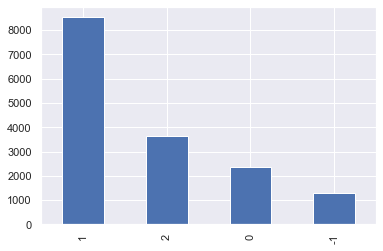

In [30]:
df_train['sentiment'].value_counts().plot(kind = 'bar')
plt.show()

From the bar graph above it can be seen that most people believe in climate change,while only a few fail to believe in man-made climate change 

Create a word Cloud for the various sentiments: wordcloud_neg(-1), wordcloud_neu(0), wordcloud_weak(1) and wordcloud_strong(2). From the Cloud, we noticed that the stems: "Chang" and "climat" has the highest frequency in all the sentiments hence they will be purged in the data engineering section because they contribute nothing to the model.
</br>We also observed that the more URLs in the tweets, the higher the sentiments about climate change.

Text(0.5, 1.0, 'Strong Sentiment')

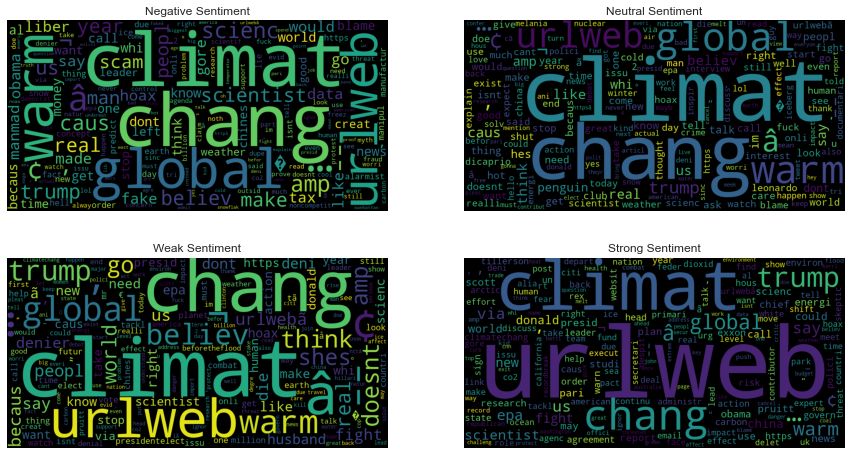

In [31]:
from PIL import Image
from wordcloud import WordCloud

wordcloud_neg = WordCloud(width = 1000, height = 500).generate_from_frequencies(sentiments[-1])
wordcloud_neu = WordCloud(width = 1000, height = 500).generate_from_frequencies(sentiments[0])
wordcloud_weak = WordCloud(width = 1000, height = 500).generate_from_frequencies(sentiments[1])
wordcloud_strong = WordCloud(width = 1000, height = 500).generate_from_frequencies(sentiments[2])
#Create a canvas
fig = plt.figure(figsize=(15,8))
# setting values to rows and column variables
rows = 2
columns = 2

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
# showing image
plt.imshow(wordcloud_neg)
plt.axis('off')
plt.title("Negative Sentiment")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
# showing image
plt.imshow(wordcloud_neu)
plt.axis('off')
plt.title("Neutral Sentiment")

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
# showing image
plt.imshow(wordcloud_weak)
plt.axis('off')
plt.title("Weak Sentiment")

# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
# showing image
plt.imshow(wordcloud_strong)
plt.axis('off')
plt.title("Strong Sentiment")


Create a dictionary of all the unique words in the tweets

In [32]:
#List of all unique words
all_words = set()
for pp in type_labels:
    for word in sentiments[pp]:
        all_words.add(word)
#Bag of words dictionary for all words in tweets
sentiments['all'] = {}
for pp in type_labels:    
    for word in all_words:
        if word in sentiments[pp].keys():
            if word in sentiments['all']:
                sentiments['all'][word] += sentiments[pp][word]
            else:
                sentiments['all'][word] = sentiments[pp][word]

Find the total number of unique words

In [33]:
total_words = sum([v for v in sentiments['all'].values()])
total_words

198827

Let's take a look at the distribution of words which occur less than 10 times in the whole dataset and we noticed that there are a lot of words that only appear once!

Text(0.5, 0, 'word frequency')

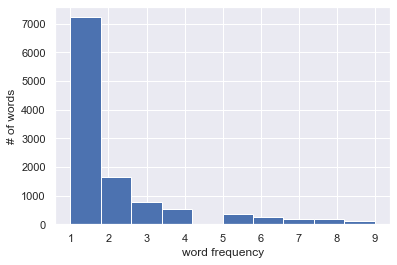

In [246]:
_ = plt.hist([v for v in sentiments['all'].values() if v < 10],bins=10)
plt.ylabel("# of words")
plt.xlabel("word frequency")

Total number of words that appeared once

In [247]:
len([v for v in sentiments['all'].values() if v == 1])

7220

As we can see from the list below, these words apart from occuring once (hence has little to no effect on the response of our model), majority of them appear to be meaningless and some are emojis.

In [34]:
rare_words = [k for k, v in sentiments['all'].items() if v==1] 
print(rare_words[:100])

['farmingagricultur', 'blac', 'cheerio', 'paraguay', 'mondaymood', 'untest', 'punchi', 'sandal', 'finnish', 'muslimsampmexican', 'affront', 'compact', 'resl', 'triggerhappi', 'nem', 'sunburn', 'anomali', 'coastsid', 'torch', 'reco', 'patient', 'electoralcolleg', 'brunt', 'eccentr', 'unã', 'enã', 'forgiv', 'pagew', 'populist', 'defra', 'frye', 'nukesor', 'surreal', 'droughtfamin', 'dtf', 'lunaci', 'guiltynotguilti', 'nonwhit', 'nostalg', 'blackfriday', 'puanã', 'headco', 'floridatrump', 'furi', 'deregul', '2action', 'vasectomi', 'pelt', 'moos', 'climatedeclar', 'carbonjam', 'adp', 'anartica', 'rene', 'dialogu', 'wrp', 'maxin', 'mista', 'winã', 'degreesat', 'opengov', 'countryã', 'iwd', 'koender', 'greenshift', 'petterstordalen', 'managem', 'natal', 'climatecã', '161', 'edmead', '🙋🏼', 'babyboom', 'roundtabl', 'ambos', 'materialist', 'unconstitut', 'waitwhat', 'plzz', 'crafter', 'wildros', 'usag', 'whore', '1970', 'catchup', 'modimakesusproud', '210', 'templ', 'conflic', 'destructi', 'not

from the summary of words less than 10 times below, we can see they account for only 11% of all the words hence can be discarded.

In [35]:
# how many words appear more than 10 times?
# how many words of the total does that account for?
print("unique words appearing less than 10 times: ", len([v for v in sentiments['all'].values() if v < 10]))
print("total words appearing less than 10 times: ", sum([v for v in sentiments['all'].values() if v < 10]))
print("% of words less than 10 times: ", (sum([v for v in sentiments['all'].values() if v < 10]))/total_words)

unique words appearing less than 10 times:  11300
total words appearing less than 10 times:  22218
% of words less than 10 times:  0.11174538669295418


__Preprocessing for  the test dataset__

__initialize the count vectorizer__

__TF-IDF Vectorizer__

TF-IDF stands for Term Frequency-Inverse Document Frequency.It is a commonly used NLP model that helps you determine the most important words in each document in the corpus.The idea behind TFIDF is that each corpus may have shared words beyond just the stopwords.These common words are like stop words and should be removed or atleast downweighted in importance.

# 6. Modelling

## 6.1. Naive Bayes Model


Naive bayes is most commonly used for testing NLP classification because of its basis in probability.Naive bayes algorithm attempts to answe the question 'Given a particular piece of data how likely is the outcome?'
Each word acts as a feature from our count vectorizer helping classify our message using probability.

In [45]:
from sklearn.naive_bayes import MultinomialNB

MultinomialNB works well with count vectorizer as it expects integer inputs

__modelling with the count vectors__

__submission__

__modelling with the tfidf vectors__

# 7. Conclusion

# 8. Recommendations